In [1]:
import numpy as np
import cv2
import sys
from scipy.ndimage.filters import convolve
from matplotlib import pyplot as plt
from matplotlib.pyplot import quiver
import random
%matplotlib inline

In [2]:
def ImageDerivatives(im1, im2):
#  using robert mask
    kX = np.array([[-1, 1],
                     [-1, 1]])
    kY = np.array([[-1,-1],
                         [ 1, 1]])
    kt_i1 = np.array([[-1, -1], [-1, -1]])
    kt_i2 = np.array([[1, 1], [1, 1]])
    fx = convolve(im1,kX) + convolve(im2,kX)
    fy = convolve(im1,kY) + convolve(im2,kY)
    ft = convolve(im1, kt_i1) + convolve(im2, kt_i2)
    return fx,fy,ft


def smoothing(image, n):
    kernel = np.ones((n,n), np.float32) / (n*n)
    filtered_img = cv2.filter2D(image, -1, kernel)
    return filtered_img

In [3]:
def LucasKanade(gframe1, gframe2, U, V):
    # params 
    feature_params = dict( maxCorners = 10000,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    
    features = cv2.goodFeaturesToTrack(gframe1, mask = None, **feature_params)
    
    feature = np.int0(features)
    
    gframe1 = gframe1.astype(np.float32)
    gframe2 = gframe2.astype(np.float32)
    
    
    
    Fx, Fy, Ft = ImageDerivatives(gframe1, gframe2)
    for each_feature in feature:
        j, i = each_feature.ravel()
        FX = np.array([Fx[i-1,j-1],Fx[i,j-1],Fx[i-1,j-1],Fx[i-1,j],Fx[i,j],Fx[i+1,j],Fx[i-1,j+1],Fx[i,j+1],Fx[i+1,j-1]])
        FY = np.array([Fy[i-1,j-1],Fy[i,j-1],Fy[i-1,j-1],Fy[i-1,j],Fy[i,j],Fy[i+1,j],Fy[i-1,j+1],Fy[i,j+1],Fy[i+1,j-1]])
        FT = np.array([Ft[i-1,j-1],Ft[i,j-1],Ft[i-1,j-1],Ft[i-1,j],Ft[i,j],Ft[i+1,j],Ft[i-1,j+1],Ft[i,j+1],Ft[i+1,j-1]])
        A = np.column_stack((FX, FY))
        ft = FT.reshape(-1, 1)
        A_transpose = np.transpose(A)
        A_ = np.linalg.pinv(np.dot(A_transpose, A))
        u, v = np.squeeze(np.dot(np.dot(A_, A_transpose), ft))
        U[i][j]+=u
        U[i][j]+=v
    
    return U, V

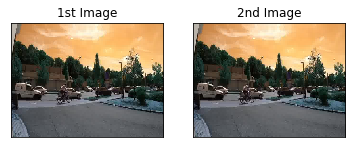

In [4]:

file1path_ = 'images/opticalflow/'
file2path_ = 'images/opticalflow/'

initialize = True
for i in range(139, 150):
    j = i+1
    fileno1 = '%.4d'%i
    fileno2 = '%.4d'%j
    
    file1path = file1path_ + fileno1 +'.jpg'
    file2path = file2path_+ fileno2 +'.jpg'
    frame1 = cv2.imread(file1path)
    frame2 = cv2.imread(file2path)
    gframe1 = cv2.imread(file1path, 0)
    gframe2 = cv2.imread(file2path, 0)
    gframe2.resize(gframe1.shape[0], gframe1.shape[1])
    if initialize:
        U = np.zeros(list(gframe1.shape))
        V = np.zeros(list(gframe1.shape))
        initialize = False
    
    U, V = LucasKanade(smoothing(gframe1, 2), smoothing(gframe2,2), U, V)

# U, V = optimal_vector(U, V, threshold=50)
plt.subplot(121),plt.imshow(frame1, cmap = 'gray')
plt.title('1st Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(frame2, cmap = 'gray')
plt.title('2nd Image'), plt.xticks([]), plt.yticks([])
plt.show()

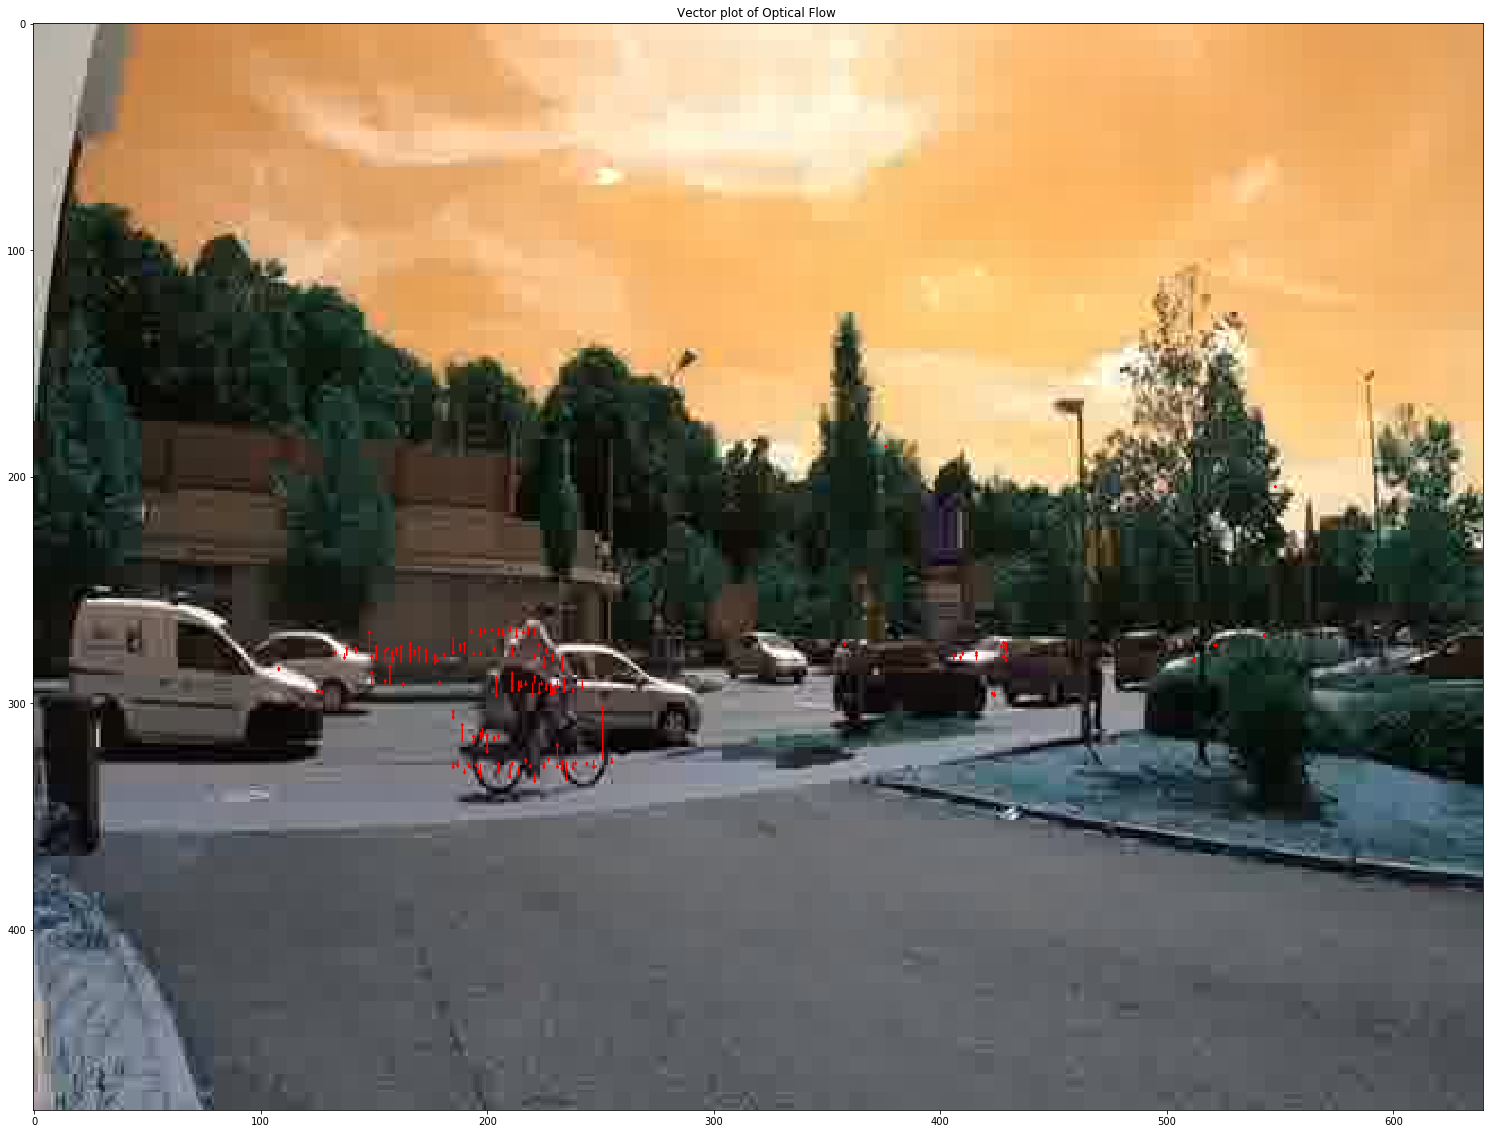

In [5]:

plt.figure(figsize=(40,20))
plt.title('Vector plot of Optical Flow ')
plt.imshow(frame1,cmap = 'gray')
r, l = gframe1.shape
for row in range(r):
    for col in range(l):
        if abs(U[row,col])>0.3 or abs(V[row,col])>0.3: 
            plt.arrow(col,row,V[row,col],U[row,col],head_width = 1, head_length = 1, color = 'red')

plt.show()

In [6]:
# https://github.com/opencv/opencv/blob/master/samples/python/opt_flow.py
def drawOpticalflow(img, U,V, step=7):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    
    flow = np.dstack((U,V))
  
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.2)
    color = (255, 0, 0) 
    thickness = 2
    cv2.polylines(img, lines, 0, color, thickness)

    plt.figure(figsize=(40,20))
    plt.imshow(img, cmap='gray')
    plt.title('optical flow'), plt.xticks([]), plt.yticks([])


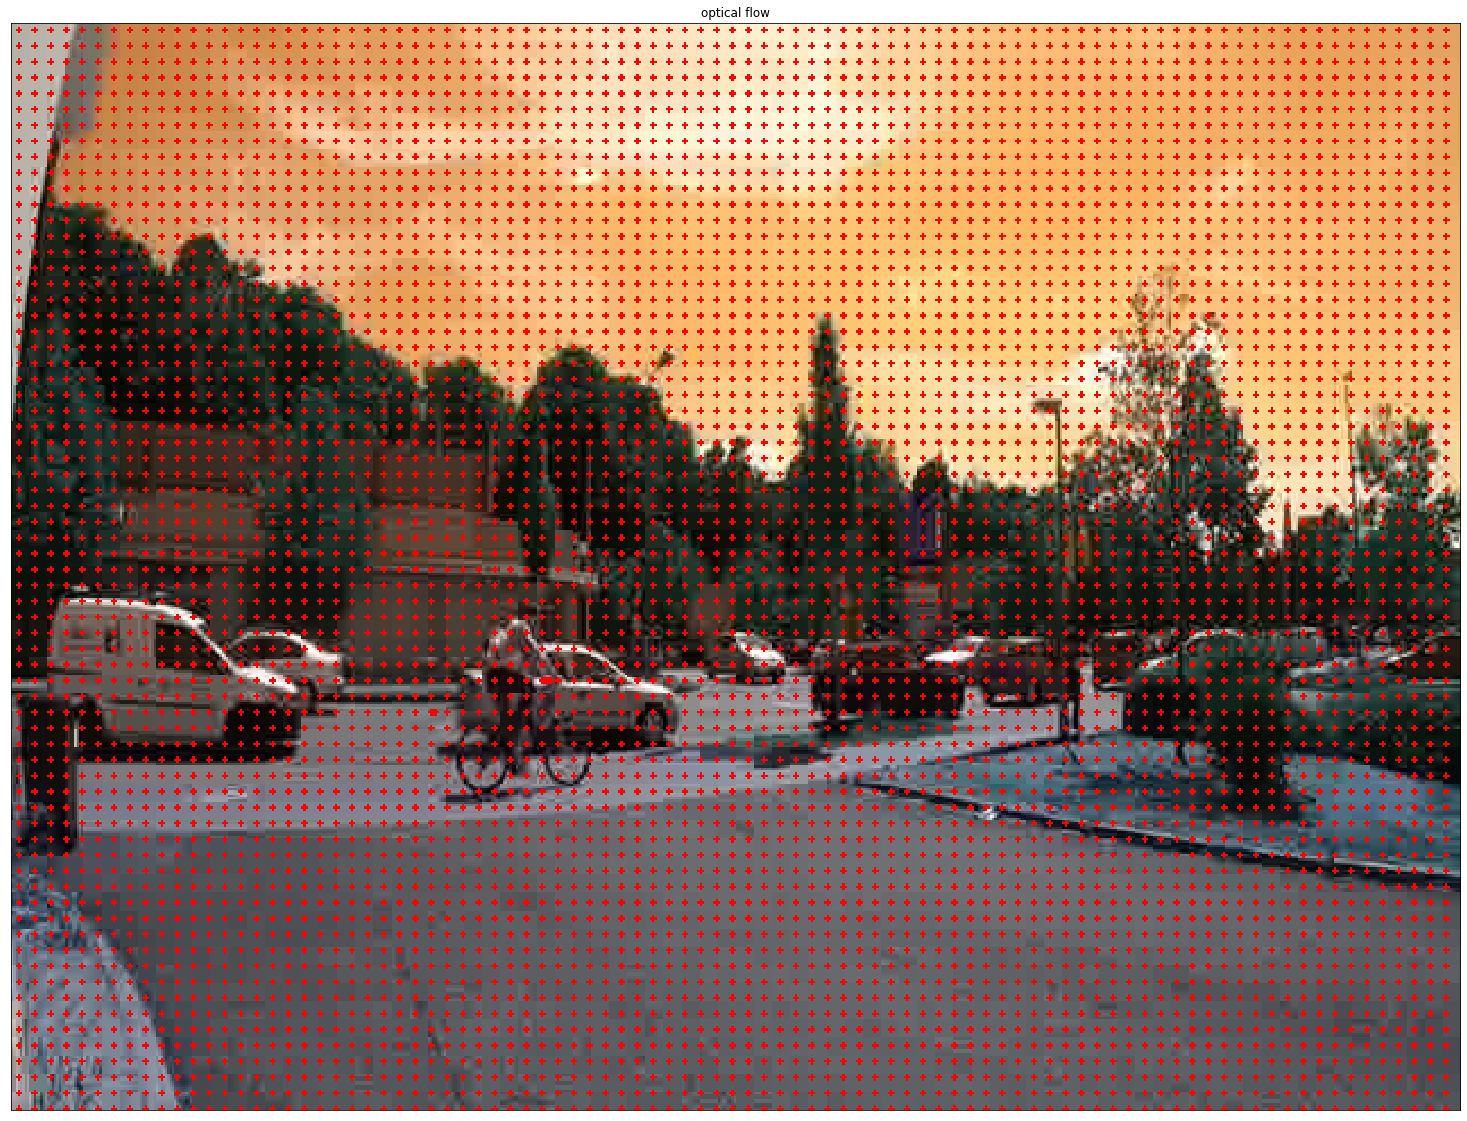

In [7]:
drawOpticalflow(frame2, U, V)